# Cross sell prediction Machine Learning (Neural Network)

I'm going to build a model to predict whether the policyholders frokm past year will also interested in Vehicle insurance provided by the company.

In [ ]:
!pip install imblearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, auc

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Description
I'm going to look if there are null fields. 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298752 entries, 0 to 298751
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    298752 non-null  int64  
 1   Gender                298752 non-null  object 
 2   Age                   298752 non-null  int64  
 3   Driving_License       298752 non-null  int64  
 4   Region_Code           298752 non-null  float64
 5   Previously_Insured    298752 non-null  int64  
 6   Vehicle_Age           298752 non-null  object 
 7   Vehicle_Damage        298752 non-null  object 
 8   Annual_Premium        298752 non-null  float64
 9   Policy_Sales_Channel  298752 non-null  float64
 10  Vintage               298751 non-null  float64
 11  Response              298751 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 27.4+ MB


I'm going to have a briefly look at the data.

NB! Policy sales channel is anonymised. It is a code for the channel of outreaching the customer: different agents, over mail, over phone, in persona, ads.

In [ ]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,298752.000000,298752.000000,298752.000000,298752.000000,298752.000000,298752.000000,298752.000000,298751.000000,298751.000000
mean,149376.500000,38.815235,0.997858,26.383552,0.457828,30537.424633,112.116716,154.336260,0.122999
std,86242.418148,15.494707,0.046235,13.231482,0.498219,17247.686932,54.142181,83.648025,0.328436
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,74688.750000,25.000000,1.000000,15.000000,0.000000,24391.000000,29.000000,82.000000,0.000000
50%,149376.500000,36.000000,1.000000,28.000000,0.000000,31645.000000,133.000000,154.000000,0.000000
75%,224064.250000,49.000000,1.000000,35.000000,1.000000,39361.250000,152.000000,227.000000,0.000000
max,298752.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


##Exploratory Data Analysis

Let's have a look at the basic traits of the data e.g. what is the distribution of numerical features?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of response')

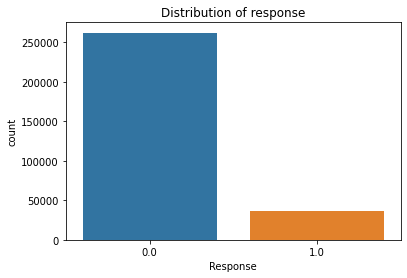

In [ ]:
#Dependent variable

sns.countplot(train['Response'])
plt.title("Distribution of response")

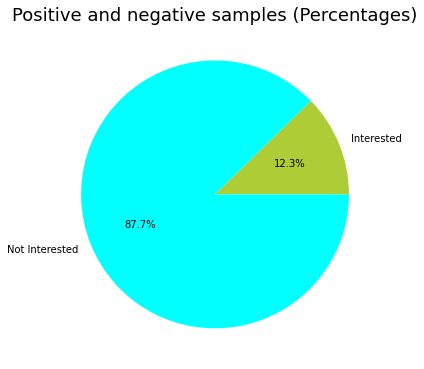

In [ ]:
#Calculating positive and negative sample in percentage 
positive_percent = len(train[train['Response'] == 1])/len(train)*100 
negative_percent = len(train[train['Response'] == 0])/len(train)*100
percentages = [positive_percent,negative_percent]

#Creating a pie chart
plt.figure(figsize = (6,8))
plt.pie(percentages, labels=['Interested','Not Interested'], autopct = '%.1f%%', colors = ['#aecc35', 'cyan'])
plt.title('Positive and negative samples (Percentages)', fontsize = 18)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of gender')

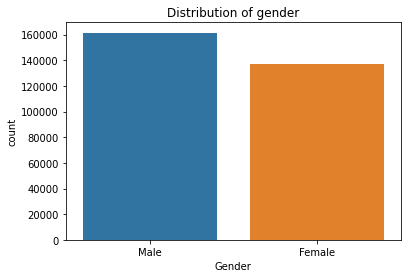

In [ ]:
#Independent variables
sns.countplot(train['Gender'])
plt.title("Distribution of gender")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Driving License')

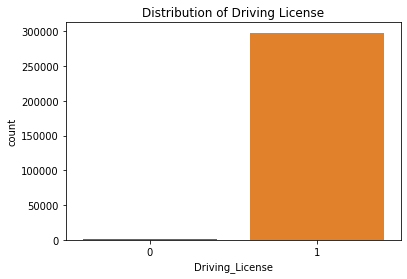

In [ ]:
#Independent variable
sns.countplot(train['Driving_License'])
plt.title("Distribution of Driving License")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Annual Premium')

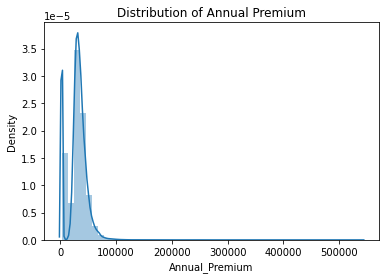

In [ ]:
#Continuous variables --> we get the distribution of data 
sns.distplot(train['Annual_Premium'])
plt.title("Distribution of Annual Premium")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Age')

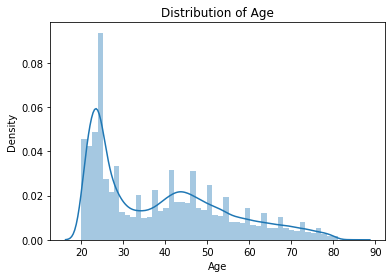

In [ ]:
#Continuous variables  
sns.distplot(train['Age'])
plt.title("Distribution of Age")

In [ ]:
#EDA -- Bi-variable 
train.groupby("Gender")["Response"].value_counts(normalize=True)

Gender  Response
Female  0.0         0.895548
        1.0         0.104452
Male    0.0         0.861235
        1.0         0.138765
Name: Response, dtype: float64

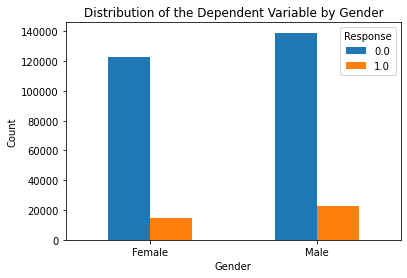

In [ ]:
#Plotting results
train.groupby("Gender")['Response'].value_counts().unstack().plot(kind='bar');
plt.title("Distribution of the Dependent Variable by Gender");
plt.xticks(rotation = 360);
plt.ylabel("Count");

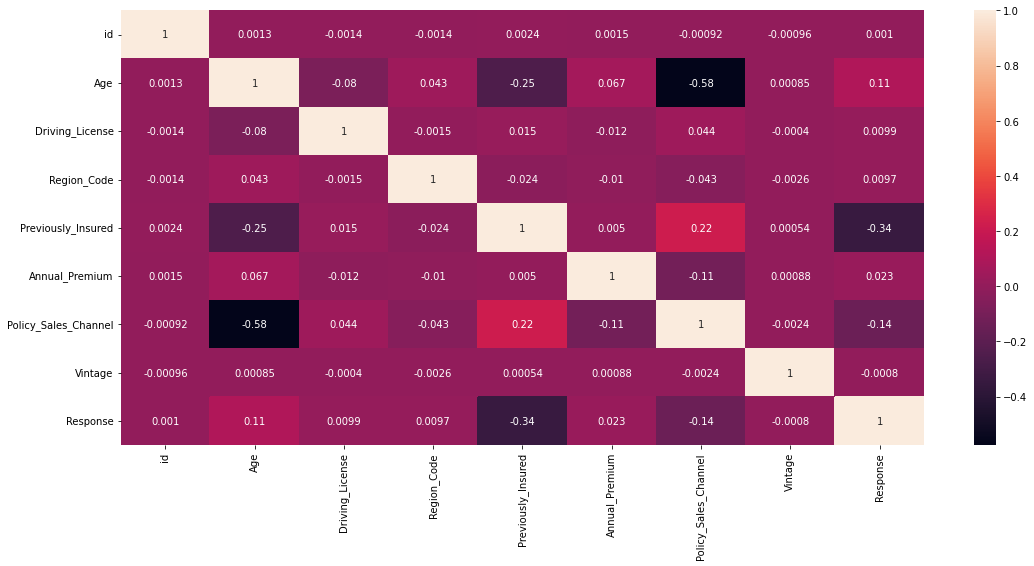

In [ ]:
#Correlation analysis 

plt.figure(figsize = (18,8))
sns.heatmap(train.corr(), annot = True)
plt.show()

## Feature Engineering 
It is a work of art in data science and machine learning. It creates features from existing raw data in order to incrememnt the predictive power of the machine learning algorithms.

I created new features using different strategic combinations of existing variables:
1. Mean premium damage
2. Mean premium vehicle age
3. Mean premium per Region code
4. Mean premium per Policy sales channel

In [ ]:
# Let's combine the data
ntrain = train.shape[0]
ntest = test.shape[0]
y = train['Response']
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data = all_data.drop(['Response', 'id'],axis = 1)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (425789, 10)


In [ ]:
#Combining data
all_data['Mean_Premium_Damage'] = all_data.groupby('Vehicle_Damage')['Annual_Premium'].transform('mean')
all_data['Mean_Premium_VehicleAge'] = all_data.groupby('Vehicle_Age')['Annual_Premium'].transform('mean')
all_data['Mean_Premium_Per_Region_Code'] = all_data.groupby("Region_Code")['Annual_Premium'].transform('mean')
all_data['Mean_Premium_Per_Policy_Sales_Channel'] = all_data.groupby("Policy_Sales_Channel")['Annual_Premium'].transform('mean')
all_data.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Mean_Premium_Damage,Mean_Premium_VehicleAge,Mean_Premium_Per_Region_Code,Mean_Premium_Per_Policy_Sales_Channel
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217.0,30699.730849,35624.269700,38656.901618,33613.395165
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183.0,30364.665934,30482.220793,24445.899431,33613.395165
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27.0,30699.730849,35624.269700,38656.901618,33613.395165
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203.0,30364.665934,30102.209234,27703.286513,30905.431961
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39.0,30364.665934,30102.209234,30918.820242,30905.431961


Generally, the below 2 techniques are used for feature engineering of categorical variables.
1. One-hot encoding
2. Label encoding

This can be done using the “get_dummies” functionality 

In [ ]:
gender = {'Male': 0, 'Female': 1}
driving_licence = {0: 0, 1: 1}
previously_insured = {0:1, 1:0}
vehicle_age ={'> 2 Years':2, '1-2 Year':1, '< 1 Year':0}
vehicle_damage = {'Yes':1, 'No':0}


In [ ]:
all_data['Gender'] = all_data['Gender'].map(gender)
all_data['Driving_License'] = all_data['Driving_License'].map(driving_licence)
all_data['Previously_Insured'] = all_data['Previously_Insured'].map(previously_insured)
all_data['Vehicle_Age'] = all_data['Vehicle_Age'].map(vehicle_age)
all_data['Vehicle_Damage'] = all_data['Vehicle_Damage'].map(vehicle_damage)

all_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Mean_Premium_Damage,Mean_Premium_VehicleAge,Mean_Premium_Per_Region_Code,Mean_Premium_Per_Policy_Sales_Channel
0,0,44,1,28.0,1,2,1,40454.0,26.0,217.0,30699.730849,35624.269700,38656.901618,33613.395165
1,0,76,1,3.0,1,1,0,33536.0,26.0,183.0,30364.665934,30482.220793,24445.899431,33613.395165
2,0,47,1,28.0,1,2,1,38294.0,26.0,27.0,30699.730849,35624.269700,38656.901618,33613.395165
3,0,21,1,11.0,0,0,0,28619.0,152.0,203.0,30364.665934,30102.209234,27703.286513,30905.431961
4,1,29,1,41.0,0,0,0,27496.0,152.0,39.0,30364.665934,30102.209234,30918.820242,30905.431961


## Scaling the numerical features

In [ ]:
from sklearn.preprocessing import StandardScaler

#Numerical columns
numerical_cols = ['Age','Vintage','Region_Code','Policy_Sales_Channel']

sc = StandardScaler()
all_data[numerical_cols] = sc.fit_transform(all_data[numerical_cols])

mean_cols = ['Mean_Premium_Damage', 'Mean_Premium_VehicleAge', 'Mean_Premium_Per_Region_Code','Mean_Premium_Per_Policy_Sales_Channel']

mm = MinMaxScaler()
all_data[['Annual_Premium']] = mm.fit_transform(all_data[['Annual_Premium']])
all_data[mean_cols] = mm.fit_transform(all_data[mean_cols])

all_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Mean_Premium_Damage,Mean_Premium_VehicleAge,Mean_Premium_Per_Region_Code,Mean_Premium_Per_Policy_Sales_Channel
0,0,0.335752,1,0.120504,1,2,1,0.070366,-1.586811,0.749165,1.0,1.000000,1.000000,0.632666
1,0,2.402125,1,-1.769845,1,1,0,0.057496,-1.586811,0.342719,0.0,0.068817,0.604839,0.632666
2,0,0.529475,1,0.120504,1,2,1,0.066347,-1.586811,-1.522152,1.0,1.000000,1.000000,0.632666
3,0,-1.149453,1,-1.164933,0,0,0,0.048348,0.737447,0.581805,0.0,0.000000,0.695416,0.577370
4,1,-0.632860,1,1.103486,0,0,0,0.046259,0.737447,-1.378701,0.0,0.000000,0.784829,0.577370


## Train / Validation / Test split
Separate train and test data from all data dataset

In [ ]:
train_x = all_data[:ntrain]
test_x = all_data[ntrain:]

In [ ]:
#Importing train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x,y,test_size=0.10,random_state=42)

## Model development
This is a classification proble, so I can develop classification model to predict the results.

I decided to developing a Neural Network for predicting the values. I used RMSprop optimization algorithm for optimizing loss function. 

In [ ]:
#!pip install keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
      output_bias = tf.keras.initilizers.Constant(output_bias)
  model = keras.Sequential([
    keras.layers.Dense(
        16, activation= 'relu',
        input_shape = (X_train.shape[-1],)),
    keras.layers.Dense(
        32,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid',
                       bias_initializer=output_bias),                       
  ])

  model.compile(
      optimizer = keras.optimizers.RMSprop(lr=0.001),
      loss = keras.losses.BinaryCrossentropy(),
      metrics = metrics)
  
  return model

Then I train the model for 100 epochs. To keep track of how well the model is performing for each epoch, the model will run in both train and test data along with calculating the loss function

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
model = make_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 16)                240       
                                                                 
 dense_45 (Dense)            (None, 32)                544       
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 33        
                                                                 
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Evaluating

For classification tasks I used Area under the Curve (AUC)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve
y_pred = model.predict(X_test) # idk the reason for predict_proba

frp,trp, threshold = roc_curve(y_test,y_pred)

roc_auc = auc(frp,trp)


Text(0.5, 0, 'False positive rate')

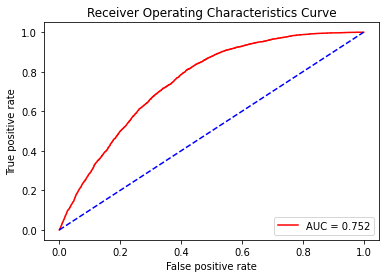

In [ ]:
#Plotting results
plt.title('Receiver Operating Characteristics Curve')
plt.plot(frp,trp,'r',label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

#Prediction

In [ ]:
y_pred_test = model.predict(test_x, batch_size = BATCH_SIZE)
Prediction = pd.DataFrame(y_pred_test)
Prediction



,0
0,0.175748
1,0.243675
2,0.261087
3,0.231076
4,0.223528
...,...
127032,0.182794
127033,0.247682
127034,0.176659
127035,0.211099


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Prediction')

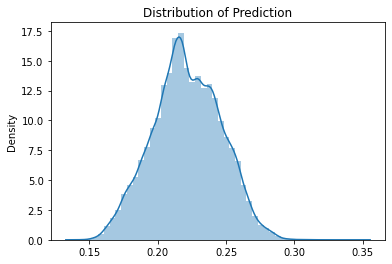

In [ ]:
sns.distplot(Prediction)
plt.title("Distribution of Predictions")